In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

from tensorflow import keras

import utils

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams["figure.autolayout"] = True

In [2]:
df_genre = pd.read_csv("all_genre.csv")

In [3]:
df_genre.head()

,id,preview_url,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,duration_ms
0,1EzrEOXmMH3G43AXT1y7pA,https://p.scdn.co/mp3-preview/28154061cbfda9d5...,acoustic,0.703,0.444,11,-9.331,1,0.0417,0.55900,0.000000,0.0973,0.712,150.960,https://api.spotify.com/v1/audio-analysis/1Ezr...,242947
1,4E6cwWJWZw2zWf7VFbH7wf,https://p.scdn.co/mp3-preview/7ed132f9327678a8...,acoustic,0.583,0.786,2,-3.142,0,0.0301,0.02080,0.000000,0.1880,0.573,123.055,https://api.spotify.com/v1/audio-analysis/4E6c...,258827
2,53QF56cjZA9RTuuMZDrSA6,https://p.scdn.co/mp3-preview/bf486b927761bf99...,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.69400,0.000000,0.1150,0.139,133.406,https://api.spotify.com/v1/audio-analysis/53QF...,240166
3,0IktbUcnAGrvD03AWnz3Q8,https://p.scdn.co/mp3-preview/a89bf59628fb81ad...,acoustic,0.625,0.414,0,-8.700,1,0.0369,0.29400,0.000000,0.1510,0.669,130.088,https://api.spotify.com/v1/audio-analysis/0Ikt...,189613
4,6Uy6K3KdmUdAfelUp0SeXn,https://p.scdn.co/mp3-preview/43d2cef16aa11c7d...,acoustic,0.551,0.836,10,-3.838,0,0.0524,0.00502,0.000021,0.0425,0.758,185.063,https://api.spotify.com/v1/audio-analysis/6Uy6...,220573


In [4]:
parent_dir = "E:/genre_classification_data/music_data/"
list_file_path = []

for genre in df_genre['genre'].unique():
    genre_dir = os.path.join(parent_dir, genre)
    audio_files = os.listdir(genre_dir)
    file_paths = [os.path.join(genre_dir, file) for file in audio_files if file.endswith(".wav")]
    list_file_path.extend(file_paths)
    
df_genre['file_path'] = list_file_path

In [5]:
filename =  df_genre.iloc[0]['file_path']


x, sr = librosa.load(filename, sr=None, mono=True,offset=0.0, duration=5.0)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 0, 5
ipd.Audio(data=x[start*sr:end*sr], rate=sr)
x.shape

Duration: 5.00s, 220500 samples


(220500,)

## wave radio

(44100,)

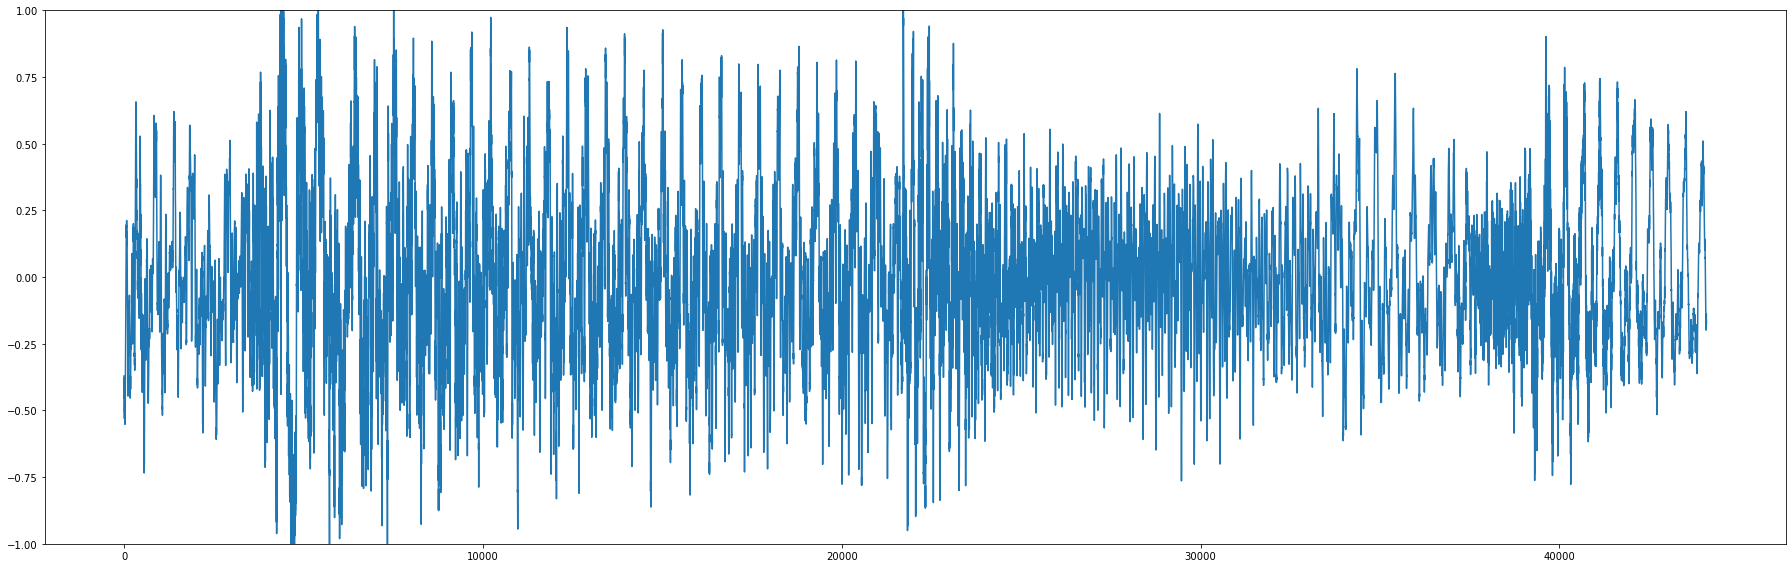

In [6]:
plt.figure()
plt.plot(x[start:start+sr])
plt.ylim((-1, 1));
x[start:start+sr].shape

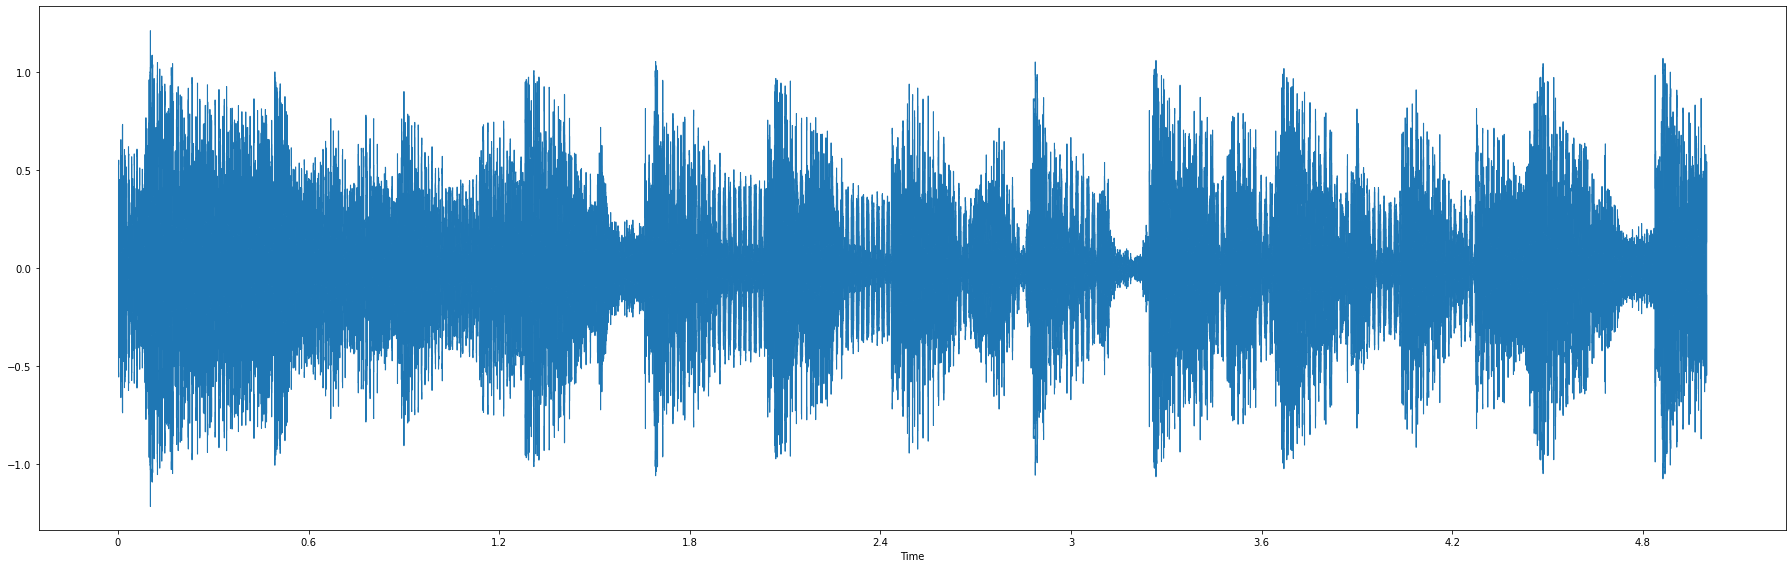

In [7]:
librosa.display.waveshow(x,sr=sr);

## chroma feature

(12, 431)

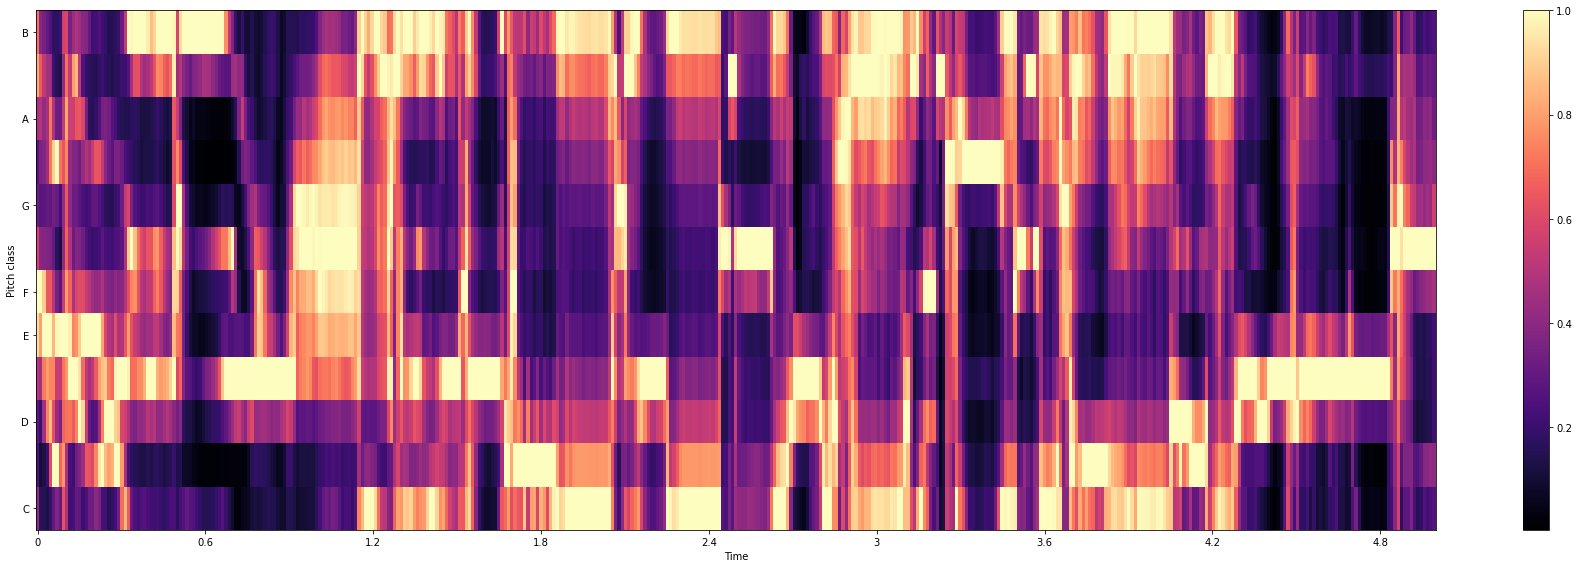

In [8]:
chroma = librosa.feature.chroma_stft(y=x,sr=sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma,sr=sr, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img)
chroma.shape

(12, 87)

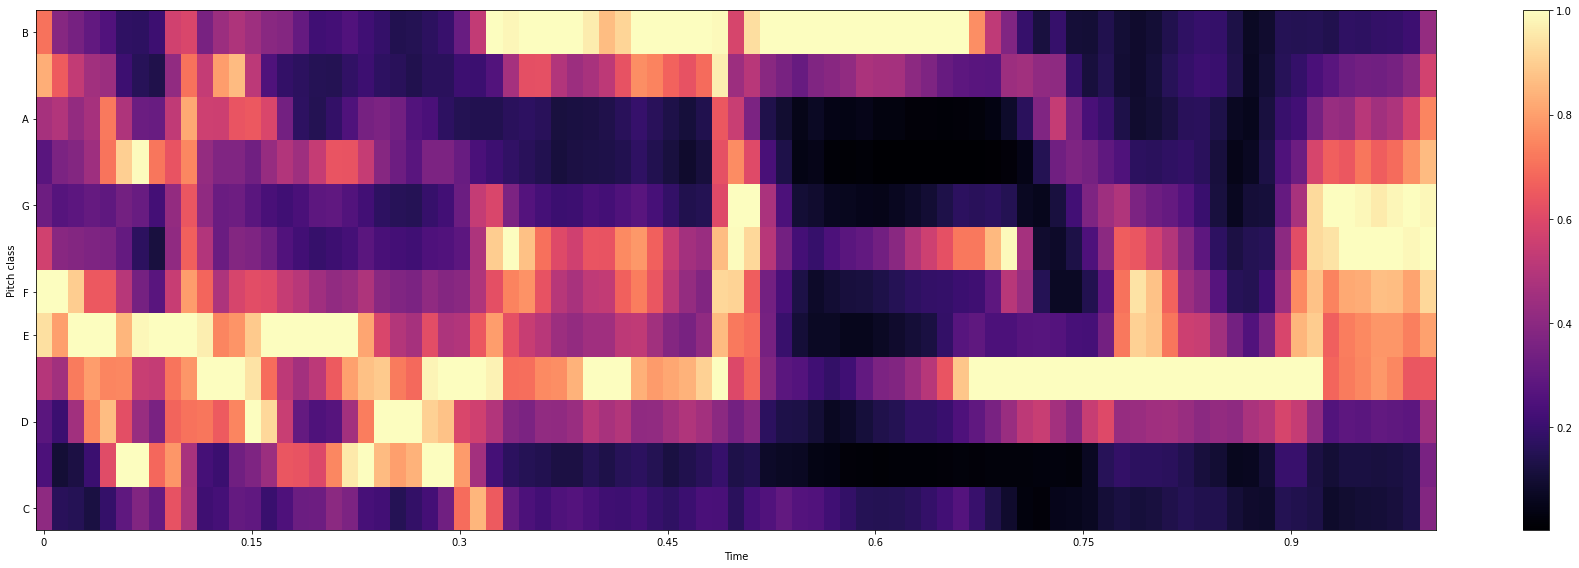

In [9]:
chroma = librosa.feature.chroma_stft(y=x[start:start+sr],sr=sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma,sr=sr, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img)
chroma.shape

## group genre

หาข้อมูลสำหรับการรวมกลุ่มเพลงโดยอ้างอิงจาก 3 แหล่งข้อมูลนี้
- https://www.chosic.com/list-of-music-genres/
- https://www.gemtracks.com/guides/view.php?title=complete-list-of-music-genres&id=298
- https://chat.openai.com/

In [10]:
f = open("group-genre.txt","r")
text = f.read()
f.close()

genre_group = {}
class_name = []
group_genre = {main_genre : [genre.strip() for genre in sub_genre.split(",")] for main_genre,sub_genre in [i.split(":") for i in text.split("\n")]}

for main_genre,sub_genre in [i.split(":") for i in text.split("\n")]:
    sub_genre = [genre.strip() for genre in sub_genre.split(",")]
    main_genre = main_genre.lower()
    for genre in sub_genre:
        genre_group[genre] = main_genre
        if main_genre not in class_name:
            class_name.append(main_genre)

In [11]:
map_class = {main_genre : num for num,main_genre in zip(range(len(class_name)),class_name)}

In [12]:
df_genre['main_genre'] = [map_class.get(genre_group.get(genre)) for genre in df_genre.genre]

In [13]:
df_genre.loc[df_genre.main_genre == 21].head()

,id,preview_url,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,duration_ms,file_path,main_genre
250,1q8NdCAQ9QUjpYiqzdd3mv,https://p.scdn.co/mp3-preview/6632fb09b449bde7...,afrobeat,0.829,0.878,9,-5.951,1,0.1010,0.0959,0.000,0.776,0.883,87.991,https://api.spotify.com/v1/audio-analysis/1q8N...,239307,E:/genre_classification_data/music_data/afrobe...,21
251,2Y3x5VcEAxLNmVHxQOE0jB,https://p.scdn.co/mp3-preview/ff0614b171f2ce8b...,afrobeat,0.778,0.399,1,-8.984,1,0.0858,0.0751,0.835,0.103,0.321,137.305,https://api.spotify.com/v1/audio-analysis/2Y3x...,67720,E:/genre_classification_data/music_data/afrobe...,21
252,6Dq2LzijkY9WNPwBGDah4L,https://p.scdn.co/mp3-preview/70858bcfe6c190b1...,afrobeat,0.463,0.382,5,-11.682,1,0.0278,0.8970,0.263,0.108,0.638,74.573,https://api.spotify.com/v1/audio-analysis/6Dq2...,209160,E:/genre_classification_data/music_data/afrobe...,21
253,4pR4oQJULf7FDB54TleMyH,https://p.scdn.co/mp3-preview/420a1e6f09ba7216...,afrobeat,0.443,0.778,0,-7.564,0,0.2660,0.2410,0.000,0.215,0.628,128.250,https://api.spotify.com/v1/audio-analysis/4pR4...,168000,E:/genre_classification_data/music_data/afrobe...,21
254,4bJ7tMJqfYmkKgCYzaaG4B,https://p.scdn.co/mp3-preview/9dc0e96d3662e681...,afrobeat,0.571,0.508,11,-8.118,0,0.0254,0.5320,0.951,0.161,0.102,96.825,https://api.spotify.com/v1/audio-analysis/4bJ7...,174827,E:/genre_classification_data/music_data/afrobe...,21


In [14]:
df_data = df_genre.drop(df_genre.loc[df_genre.main_genre == 21].index)

ลบหมดหมู่ที่ไม่สามารถใช้งานได้ เนื่องจากเหตุผลต่าง ๆ เช่น 
- มีหลากหลายหมวดในหมวดเดียวกัน : anime
- เป็นนามธรรมเกินไป : party

โดยได้ลบออกไป 24 หมวด เหลือ 89 หมวด แบ่งได้เป็น 21 class

In [15]:
len(df_genre.genre.unique()) - len(df_data.genre.unique()), len(df_data.genre.unique())

(24, 89)

In [16]:
class_name.remove("not_use")
map_class.pop('not_use')
class_len = len(class_name)

In [17]:
class_len

21

In [18]:
len(df_data),len(df_genre)

(24750, 30750)

In [19]:
print(map_class.get(0))

None


In [20]:
n_genre_in_main_genre = df_data.groupby('main_genre')['genre'].nunique()

In [21]:
max_n_samples = 720

balanced_data = pd.DataFrame(columns=df_data.columns)

for main_genre in df_data['main_genre'].unique():
    n_genre = n_genre_in_main_genre[main_genre]
    n_sample = max_n_samples // n_genre
    for genre in df_data[df_data["main_genre"] == main_genre]["genre"].unique():
        genre_data = df_data[(df_data["main_genre"] == main_genre) & (df_data["genre"] == genre)]
        sampled_data = genre_data.sample(n=n_sample, random_state=1234)
        
        balanced_data = pd.concat([balanced_data, sampled_data])
    print(balanced_data[balanced_data["main_genre"] == main_genre].groupby('genre').size())
    print("sum genre : {}".format(len(balanced_data[balanced_data["main_genre"] == main_genre])))
    print("="*24)
    
balanced_data = balanced_data.sample(frac=1, random_state=1234)

genre
acoustic             240
singer-songwriter    240
songwriter           240
dtype: int64
sum genre : 720
genre
alt-rock       90
goth           90
hard-rock      90
j-rock         90
psych-rock     90
rock           90
rock-n-roll    90
rockabilly     90
dtype: int64
sum genre : 720
genre
alternative    90
emo            90
grunge         90
indie          90
indie-pop      90
power-pop      90
punk           90
punk-rock      90
dtype: int64
sum genre : 720
genre
ambient    144
chill      144
guitar     144
piano      144
sleep      144
dtype: int64
sum genre : 720
genre
black-metal    120
death-metal    120
grindcore      120
heavy-metal    120
metal          120
metalcore      120
dtype: int64
sum genre : 720
genre
bluegrass    240
folk         240
forro        240
dtype: int64
sum genre : 720
genre
blues    720
dtype: int64
sum genre : 720
genre
breakbeat        72
drum-and-bass    72
dub              72
dubstep          72
electro          72
electronic       72
hardcore     

In [22]:
from preprocess_audios_mfcc import preprocess_audios_mfcc
from preprocess_audios_chroma import preprocess_audios_chroma
from multiprocessing import cpu_count

cpus = cpu_count()
balanced_data = pd.read_csv('data_preprocess/balanced_data.csv')
data_dir = "data_preprocess/"

In [23]:
y = np.array(balanced_data['main_genre'].values)

np.save(data_dir+"y.npy",y)

In [25]:
mfccs = preprocess_audios_mfcc(balanced_data['file_path'].values,cpus-1,sr=22050,duration=None,n_mfcc=40,hop_length=512,max_length=1200)
mfcc_array = np.array(mfccs)
np.save(data_dir+'mfccs.npy', mfcc_array)

100%|████████████████████████████████████████████████████████████████████████████| 15120/15120 [09:13<00:00, 27.34it/s]


In [ ]:
chroma = preprocess_audios_chroma(balanced_data['file_path'].values,cpus-1,sr=22050,duration=None,hop_length=512,max_length=1200)
chroma_array = np.asarray(chroma)
np.save(data_dir+'chroma.npy',chroma_array)

 33%|█████████████████████████▏                                                   | 4951/15120 [05:01<08:45, 19.36it/s]

In [ ]:
# balanced_data['file_path'] = [path.rsplit('\\')[-1] for path in balanced_data['file_path']]
# balanced_data.rename(columns={"file_path": "file_name"}).head()
# balanced_data.to_csv(data_dir + 'balanced_data.csv',index=False)